In [1]:
%load_ext autoreload
%autoreload 2
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:96% !important; }</style>"))

import os
import torch
import matplotlib.pyplot as plt
from skimage.io import imread
import torch.nn as nn
import numpy as np
from skimage import img_as_ubyte
import imageio
import json
import cv2
import time
from PIL import Image

import torch.nn.functional as F

from tqdm import tqdm_notebook
# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes
import math
# Data structures and functions for rendering
from pytorch3d.structures import Meshes, Textures
from pytorch3d.renderer import (
    look_at_view_transform,
    OpenGLPerspectiveCameras, 
    SfMPerspectiveCameras,
    SfMOrthographicCameras,
    PointLights, 
    DirectionalLights,
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    TexturedSoftPhongShader,
    SoftSilhouetteShader,
    look_at_rotation,
    HardFlatShader
)

# add path for demo utils functions 
import sys
import os
import glob
sys.path.append(os.path.abspath(''))

from datetime import datetime
def now_str():
    now = datetime.now()
    month = str(now.month)
    day = str(now.day)
    hour = str(now.hour)
    minute = str(now.minute)
    sec = str(now.second)
    
    output = '[{:>02}/{:>02} {:>02}:{:>02}:{:>02}]'.format(month, day, hour, minute, sec)
    return output
def __output_log(path, strs):
    if not os.path.exists(path):
        with open(path, 'w+') as f:
            f.write(strs)
            f.close()
    else:
        with open(path, 'a+') as f:
            f.write(strs)
            f.close()
print(now_str())
print(torch.__version__)

[04/04 16:37:51]
1.4.0


In [2]:
def reproject(params, vertices, distort=False):
    R = params['R']
    T = params['T']
    fx = params['fx']
    fy = params['fy']
    cx = params['cx']
    cy = params['cy']

    E = np.array([
        [R[0,0], R[0,1], R[0,2], T[0]], 
        [R[1,0], R[1,1], R[1,2], T[1]], 
        [R[2,0], R[2,1], R[2,2], T[2]], 
        [0, 0, 0, 1]]).astype('double')
    
    if distort:
        k1 = params['k1']
        k2 = params['k2']
        k3 = params['k3']
        p1 = params['p1']
        p2 = params['p2']
        
    img_pts = []
    for i in range(len(vertices)):
        v = np.array(vertices[i])

        # extrinsics
        v4 = E.dot(np.array([v[0], v[1], v[2], 1]).astype('double'))
        xp = v4[0] / v4[2]
        yp = v4[1] / v4[2]

        if distort:
            # intrinsics
            r2 = xp**2 + yp**2
            ## radial
            radial_dist = 1 + k1*(r2) + k2*(r2*r2) + k3*(r2*r2*r2)

            ## tangential
            tan_x = p2 * (r2 + 2.0 * xp * xp) + 2.0 * p1 * xp * yp
            tan_y = p1 * (r2 + 2.0 * yp * yp) + 2.0 * p2 * xp * yp

            xp = xp * radial_dist + tan_x
            yp = yp * radial_dist + tan_y
            
        u = fx * xp + cx
        v = fy * yp + cy
        pr = 1
        nr = 0
        if (-4000*nr < u and u < pr*4000) and (-2160*nr < v and v < pr*2160):
            img_pts.append(np.array([u, v]))
    img_pts = np.array(img_pts)
    return img_pts

# Setup

In [3]:
# Setup
# device = torch.device("cuda:0")
# torch.cuda.set_device(device)
device = torch.device("cpu")
print(torch.cuda.current_device())
print(torch.cuda.get_device_name(0))

0
GeForce RTX 2070 SUPER


In [4]:
print('torch.cuda.is_available():',torch.cuda.is_available())

device_gpu = torch.device("cuda:0")
torch.cuda.set_device(device_gpu)
device_cpu = torch.device('cpu')

print('torch.cuda.current_device():', torch.cuda.current_device())
torch.cuda.ipc_collect()
print('torch.cuda.get_device_name(0):',torch.cuda.get_device_name(0))

# print('GPU memory stats ---------------------')
# gpu_mem_stats = torch.cuda.memory_stats(device=device_gpu)
# for k, v in gpu_mem_stats.items():
#     print('  {}: {}'.format(k, v))

print(torch.cuda.memory_summary(device=device_gpu, abbreviated=False))
bytes_reserved = torch.cuda.memory_reserved()
print('torch.cuda.memory_reserved(): {:,.2f} Mb'.format(bytes_reserved * 0.000001))
# Returns the current GPU memory usage by 
# tensors in bytes for a given device
bytes_alloc = torch.cuda.memory_allocated()
print('torch.cuda.memory_allocated(): {:,.2f} Mb'.format(bytes_alloc * 0.000001))

# Returns the current GPU memory managed by the
# caching allocator in bytes for a given device
bytes_cached = torch.cuda.memory_cached()
print('torch.cuda.memory_cached(): {:,.2f} Mb'.format(bytes_cached * 0.000001))



# Releases all unoccupied cached memory currently held by
# the caching allocator so that those can be used in other
# GPU application and visible in nvidia-smi
print('----- torch.cuda.empty_cache() -----')

torch.cuda.empty_cache()
bytes_reserved = torch.cuda.memory_reserved()
print('torch.cuda.memory_reserved(): {:,.2f} Mb'.format(bytes_reserved * 0.000001))
bytes_alloc = torch.cuda.memory_allocated()
print('torch.cuda.memory_allocated(): {:,.2f} Mb'.format(bytes_alloc * 0.000001))
bytes_cached = torch.cuda.memory_cached()
print('torch.cuda.memory_cached(): {:,.2f} Mb'.format(bytes_cached * 0.000001))

torch.cuda.is_available(): True
torch.cuda.current_device(): 0
torch.cuda.get_device_name(0): GeForce RTX 2070 SUPER
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |
|       from small pool |       0 B  |       0 B  |       0 B  |       0 B  |
|---------------------------------------------------------------------------|
| Active memory         |

# Model

In [5]:
class Model(nn.Module):
    def __init__(self, device, **kwargs):
        """
        image_size: a scalar. Only square image is supported in PyTorch3d
        """
        stat_str = ''
        
        super().__init__()
        stat_str += '  super().__init__(): {}\n'.format(self.get_gpu_stats(True))
        self.device = device
        stat_str += '  self.device: {}\n'.format(self.get_gpu_stats(True))
        self.cams = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']

        self.image_size = kwargs.get('image_size', None)
        stat_str += '  self.image_size: {}\n'.format(self.get_gpu_stats(True))
        
        # set ref images: [0, 255] uint8
        image_refs = kwargs.get('image_refs', None)
        self.image_refs = torch.from_numpy(np.array(image_refs).astype(np.uint8))
        stat_str += '  self.image_refs: {}\n'.format(self.get_gpu_stats(True))
        
        # set mesh
        self.meshes = kwargs.get('meshes', None)
        stat_str += '  self.meshes: {}\n'.format(self.get_gpu_stats(True))
        
        # set cameras
        self.cameras = kwargs.get('cameras', None)
        stat_str += '  self.cameras: {}\n'.format(self.get_gpu_stats(True))
        
        # init renderers
        self.renderers = self._init_renderers(self.cameras)
        stat_str += '  self.renderers: {}\n'.format(self.get_gpu_stats(True))
        
        # load texturemaps: [0.0, 1.0] float
        texturemap_shape = kwargs.get('texturemap_shape', None)
        texture_maps = torch.from_numpy(np.ones((1, texturemap_shape[0], texturemap_shape[1], texturemap_shape[2])).astype(np.float32)).to(self.device)
        self.texture_maps = nn.Parameter(texture_maps, requires_grad=True)
        stat_str += '  self.texture_maps: {}\n'.format(self.get_gpu_stats(True))
        
        # self.ones = torch.from_numpy(np.ones(self.texture_maps.shape).astype(np.float32)).to(self.device)
        self.stat_gpu = stat_str
        
    def forward(self):
        loss = 0
        images = []
        # loss_aboves = 0
        # loss_belows = 0
        stat_str = ''
        for i in range(len(self.renderers)):
            # [0.0, 1.0] float32 in gpu -> change to [0.0, 255.0] cpu
            image0 = self.renderers[i](meshes_world=self.meshes, texture_maps=self.texture_maps)
            images.append(image0)
            image = (255.0*image0.squeeze().cpu()[..., 0])

            # [0, 255] uint8 in cpu
            image_ref = self.image_refs[i]
            loss_i = (torch.mean((image - image_ref) ** 2) / 255.0).to(self.device)
            loss = loss + loss_i
            stat_str += '  [{:02}] loss computed   : {}\n'.format(i, self.get_gpu_stats(True))

            # penalize if texturemap pixel values are not within [0, 1]
#             texture_maps = self.texture_maps.squeeze()
#             belows = torch.clamp(-1.0*self.texture_maps, min=0.0)
#             n_belows = torch.clamp((belows > 0.0).sum(), min=1)
#             aboves = torch.clamp(self.texture_maps, min=1.0) - self.ones
#             n_aboves = torch.clamp((aboves > 0.0).sum(), min=1)
#             loss_below = 100 * torch.sum(belows ** 2) / n_belows
#             loss_above = 100 * torch.sum(aboves ** 2) / n_aboves
#             loss = loss + loss_i + loss_below + loss_above
#             loss_belows = loss_belows + loss_below
#             loss_aboves = loss_aboves + loss_above
        loss /= len(self.renderers)
        # loss_belows /= len(self.renderers)
        # loss_aboves /= len(self.renderers)
        return loss, images, self.texture_maps, stat_str
    
    #
    #
    #
    #
    #
    def get_gpu_stats(self, output_str=True):
        mb_reserved = torch.cuda.memory_reserved() * 0.000001
        mb_alloc = torch.cuda.memory_allocated() * 0.000001
        mb_cached = torch.cuda.memory_cached() * 0.000001
        if output_str:
            return 'alloc={:,.0f}MB | cached={:,.0f}MB | reserved={:,.0f}MB'.format(mb_alloc, mb_cached, mb_reserved)
        else:
            return mb_alloc, mb_cached, mb_reserved
    
    def _init_renderers(self, cameras):
        raster_settings = RasterizationSettings(
            image_size=self.image_size, 
            blur_radius=0.0, 
            faces_per_pixel=1, 
            bin_size = None,  # this setting controls whether naive or coarse-to-fine rasterization is used
            max_faces_per_bin = None  # this setting is for coarse rasterization
        )

        renderers = []
        for i in range(len(cameras)):
            camera = cameras[i]
            cam_pos = camera.T[0]
            R = camera.R[0]
            lights = PointLights(device=self.device, location=[[cam_pos[0], cam_pos[1], cam_pos[2]]], specular_color=[[0, 0, 0]])
#             lights = DirectionalLights(device=self.device, direction=[[-R[0, 2], -R[1, 2], 0]], specular_color=[[0, 0, 0]])
            renderer = MeshRenderer(
                rasterizer=MeshRasterizer(
                    cameras=camera,
                    raster_settings=raster_settings
                ),
                shader=TexturedSoftPhongShader(
                    device=self.device, 
                    cameras=camera,
                    lights=lights
                )
            )
            renderers.append(renderer)
        return renderers

# Load mesh, camera, images, and feed into the model

In [6]:
def load_mesh(mesh_path, device):
    # load mesh
    meshes = load_objs_as_meshes([mesh_path], device=device)
    return meshes

def load_cameras(cam_path, device):
    # load cameras
    cams = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']

    with open(cam_path, 'r') as f:
        j = json.load(f)
        camera_params = j['cam_params']

    cameras = []
    cam_params = []
    for cam_idx, cam in enumerate(cams):
        cam_param = camera_params[str(cam_idx)]
        # for undistortion
        fx = cam_param['fx']
        fy = cam_param['fy']
        cx = cam_param['cx']
        cy = cam_param['cy']
        k1 = cam_param['k1']
        k2 = cam_param['k2']
        k3 = cam_param['k3']
        p1 = cam_param['p1']
        p2 = cam_param['p2']
        
        rvec = np.float32(cam_param['rvec'])
        T = np.float32(cam_param['tvec'])
        R, _ = cv2.Rodrigues(rvec)

        R_torch = torch.from_numpy(R).unsqueeze(0)
        T_torch = torch.from_numpy(T).unsqueeze(0)

        principal_point = np.array([cx, cy]).astype(np.float32)
        principal_point = torch.from_numpy(principal_point).unsqueeze(0)
        focal_length = np.array([fx, fy]).astype(np.float32)
        focal_length = torch.from_numpy(focal_length).unsqueeze(0)
        cameras.append(SfMPerspectiveCameras(device=device, R=R_torch, T=T_torch, principal_point=principal_point, focal_length=focal_length))

        K = np.float32([[fx, 0, cx], [0, fy, cy], [0, 0, 1]])
        dist = np.float32([k1, k2, p1, p2, k3])
        cam_params.append({'K': K, 'dist': dist, 'R': R, 'T': T, 'fx': fx, 'fy': fy, 'cx': cx, 'cy': cy})
    return cameras, cam_params

def load_images(img_dir, cam_params):
    img_paths = sorted(glob.glob(img_dir + '/*.jpg'))
    image_refs0 = []
    image_refs_undistort = []
    for i, path in enumerate(img_paths):
        # img = imageio.imread(path)
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img_undist = _undistort(img, cam_params[i])
        image_refs0.append(img)
        image_refs_undistort.append(img_undist)

    w = 2160 / 2
    image_refs_cropped = []
    for i in range(len(image_refs_undistort)):
        image = image_refs_undistort[i]
        cx = image.shape[1] / 2

        image = image_refs_undistort[i].astype(np.uint8)
        img = image[:, int(cx-w):int(cx+w)]
        img = cv2.resize(img, (image_size, image_size))
        img = cv2.flip(img, -1)
        image_refs_cropped.append(img)
    return image_refs0, image_refs_undistort, image_refs_cropped
                         
def _undistort(img, cam_param):
    # undistort a single image)
    h, w = img.shape[:2]
    # cv2.undistort(src, cameraMatrix, distCoeffs[, dst[, newCameraMatrix]]) → dst
    img = cv2.undistort(img, cam_param['K'], cam_param['dist'], None, None)
    return img
                         
def load_clean_plates(img_dir, cam_params):
    img_paths = sorted(glob.glob(img_dir + '/*.pgm'))
    images0 = []
    images_undistort = []
    for i, path in enumerate(img_paths):
        # img = imageio.imread(path)
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img_undist = _undistort(img, cam_params[i])
        images0.append(img)
        images_undistort.append(img_undist)

    w = 2160 / 2
    clean_plates_cropped = []
    for i in range(len(images_undistort)):
        image = images_undistort[i]
        cx = image.shape[1] / 2

        image = images_undistort[i].astype(np.uint8)
        img = image[:, int(cx-w):int(cx+w)]
        img = cv2.resize(img, (image_size, image_size))
        img = cv2.flip(img, -1)
        clean_plates_cropped.append(img)
    return images0, images_undistort, clean_plates_cropped 

# Load

In [7]:
cams = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']
cam_path = r'D:\CalibrationData\CameraCalibration\2020_03_22_NewSuitDesignCapture\FinalCamParams\cam_params.json'
mesh_path = r'D:\1_Projects\200325_PyTorch3d_Toy\4_data\input\2020_03_28_SMPL_UV\SMPL_registration\SMPLFit_TPose.obj'
img_dir = './4_data/input/2020_03_28_SMPL_UV/SMPL_registration/TPose'
clean_plate_dir = r'D:\200330_ToJanKeller\data\input\clean_plate'

texturemap_shape = (1080, 1080, 1)
image_size = 1080

In [8]:
# cam_path = './4_data/input/CameraCalibration/2020_03_22_NewSuitDesignCapture\FinalCamParams\cam_params.json'
# mesh_path = './4_data/input/2020_03_28_SMPL_UV/SMPL_registration/SMPLFit_TPose.obj'
# img_dir = './4_data/input/2020_03_28_SMPL_UV/SMPL_registration/TPose'
# texturemap_shape = (2160, 2160, 1)
# image_size = 2160

In [9]:
device = device_gpu
meshes = load_mesh(mesh_path, device)
cameras, cam_params = load_cameras(cam_path, device)
img_refs_original, img_refs_undistorted, img_refs = load_images(img_dir, cam_params)
clean_plates_original, clean_plates_undistort, clean_plates = load_clean_plates(clean_plate_dir ,cam_params)

#### check

Image original =========
(2160, 4000) , 255 , uint8
8.64 Mb

Image cropped =========
(1080, 1080) , 255 , uint8
1.17 Mb


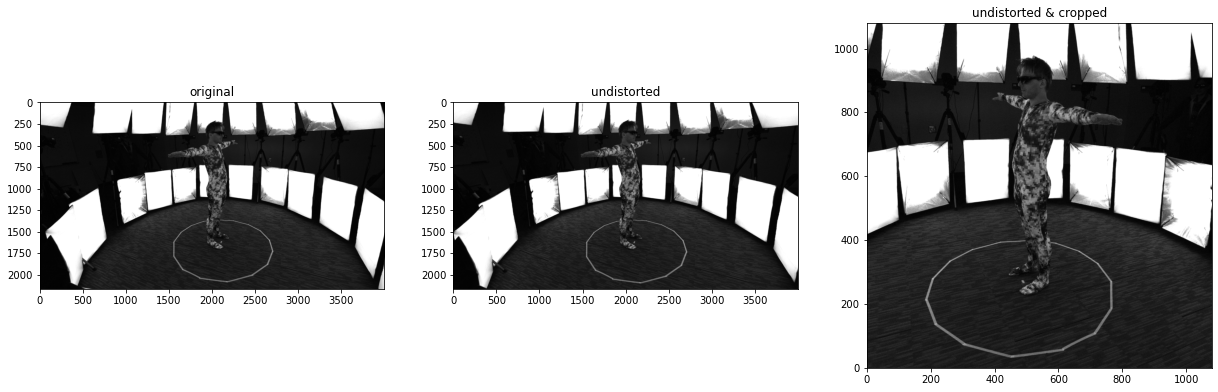

In [10]:
img = img_refs_original[0]
print('Image original =========')
print(img.shape, ',', np.max(img), ',', img.dtype)
print('{:,.2f} Mb'.format(img.nbytes * 0.000001))

print()
img = img_refs[0]
print('Image cropped =========')
print(img.shape, ',', np.max(img), ',', img.dtype)
print('{:,.2f} Mb'.format(img.size * img.itemsize * 0.000001))

i = 5
fig, ax = plt.subplots(1, 3, figsize=(21, 7))
ax[0].imshow(img_refs_original[i], cmap='gray')
ax[0].set_title('original')
ax[1].imshow(img_refs_undistorted[i], cmap='gray')
ax[1].set_title('undistorted')
ax[2].imshow(img_refs[i], cmap='gray')
ax[2].set_title('undistorted & cropped')
ax[2].invert_yaxis()
plt.show()

del img

# Init model

In [11]:
model = Model(device_gpu, img_dir=img_dir, cameras=cameras, meshes=meshes, image_refs=img_refs, texturemap_shape=texturemap_shape, image_size=image_size)
texture_maps = model.texture_maps
print('texture_maps: {:,.2f}=={:,.2f} Mb'.format(texture_maps.element_size() * texture_maps.nelement() * 0.000001, texture_maps.detach().cpu().numpy().nbytes*0.000001))
texture_maps_np = texture_maps.detach().cpu().numpy()
print('  {} {:,.2f}Mb {} {}'.format(texture_maps.shape, texture_maps_np.nbytes*0.000001, texture_maps.dtype, np.max(texture_maps_np)))
img = model.image_refs[0]
print('ref image: {}, {:,.2f} Mb'.format(img.shape, img.element_size() * img.nelement() * 0.000001))

texture_maps: 4.67==4.67 Mb
  torch.Size([1, 1080, 1080, 1]) 4.67Mb torch.float32 1.0
ref image: torch.Size([1080, 1080]), 1.17 Mb


### reprojections of obj

In [12]:
mesh_vertices = model.meshes.verts_packed().cpu()
mesh_points = []

t0 = time.time()
for cam_idx in range(16):
    params = cam_params[cam_idx]
    pts = reproject(params, mesh_vertices, distort=False)
    mesh_points.append(pts)
t1 = time.time()
print('{:.2f}s'.format(t1-t0))
print(pts.shape)
print(len(mesh_points))
del mesh_vertices



1.31s
(6890, 2)
16


### pytorch3d mesh rendering 

torch.cuda.memory_allocated(): 6.15 Mb
torch.cuda.memory_cached(): 23.07 Mb
3.70s
torch.cuda.memory_allocated(): 834.86 Mb
torch.cuda.memory_cached(): 1,054.87 Mb
rendered image: torch.Size([1, 1080, 1080, 4]), torch.float32, 1.0
rendered image: (1080, 1080, 4), float32, 1.0
texture_maps: torch.Size([1, 1080, 1080, 1]), torch.float32, 1.0


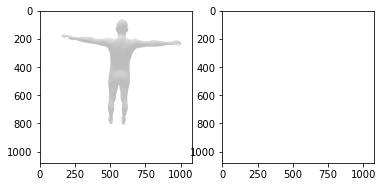

  [00] loss computed   : alloc=58MB | cached=262MB | reserved=262MB
  [01] loss computed   : alloc=109MB | cached=306MB | reserved=306MB
  [02] loss computed   : alloc=162MB | cached=365MB | reserved=365MB
  [03] loss computed   : alloc=213MB | cached=409MB | reserved=409MB
  [04] loss computed   : alloc=265MB | cached=468MB | reserved=468MB
  [05] loss computed   : alloc=317MB | cached=526MB | reserved=526MB
  [06] loss computed   : alloc=368MB | cached=570MB | reserved=570MB
  [07] loss computed   : alloc=420MB | cached=629MB | reserved=629MB
  [08] loss computed   : alloc=473MB | cached=688MB | reserved=688MB
  [09] loss computed   : alloc=524MB | cached=732MB | reserved=732MB
  [10] loss computed   : alloc=576MB | cached=791MB | reserved=791MB
  [11] loss computed   : alloc=628MB | cached=849MB | reserved=849MB
  [12] loss computed   : alloc=680MB | cached=893MB | reserved=893MB
  [13] loss computed   : alloc=732MB | cached=952MB | reserved=952MB
  [14] loss computed   : alloc=784M

In [13]:
bytes_alloc = torch.cuda.memory_allocated()
print('torch.cuda.memory_allocated(): {:,.2f} Mb'.format(bytes_alloc * 0.000001))
bytes_cached = torch.cuda.memory_cached()
print('torch.cuda.memory_cached(): {:,.2f} Mb'.format(bytes_cached * 0.000001))

t0 = time.time()
loss, images_rendered, texture_map, stats_gpu = model()
t1 = time.time()
print('{:.2f}s'.format(t1-t0))

bytes_alloc = torch.cuda.memory_allocated()
print('torch.cuda.memory_allocated(): {:,.2f} Mb'.format(bytes_alloc * 0.000001))
bytes_cached = torch.cuda.memory_cached()
print('torch.cuda.memory_cached(): {:,.2f} Mb'.format(bytes_cached * 0.000001))

print('rendered image: {}, {}, {}'.format(images_rendered[0].shape, images_rendered[0].dtype, torch.max(images_rendered[0])))
fig, ax = plt.subplots(1, 2)
# mesh from pytorch3d
img_mesh = images_rendered[0].squeeze().detach().cpu().numpy()
img_mesh2 = img_mesh
img_mesh2 = cv2.flip(img_mesh2, -1)
print('rendered image: {}, {}, {}'.format(img_mesh2.shape, img_mesh2.dtype, np.max(img_mesh2)))
print('texture_maps: {}, {}, {}'.format(texture_maps.shape, texture_maps.dtype, torch.max(texture_maps)))
ax[0].imshow(img_mesh2, cmap='gray')
ax[1].imshow(texture_maps.detach().squeeze().cpu().numpy(), cmap='gray', vmin=0, vmax=1.0)
plt.show()

print(stats_gpu)

reference image: 255 uint8 (1080, 1080)
rendered pytorch image : 1.0 float32 (1080, 1080, 3) , 14.00 Mb 1.0
rendered pytorch image2: 1.0 float32 (1080, 1080, 3) , 14.00 Mb 1.0


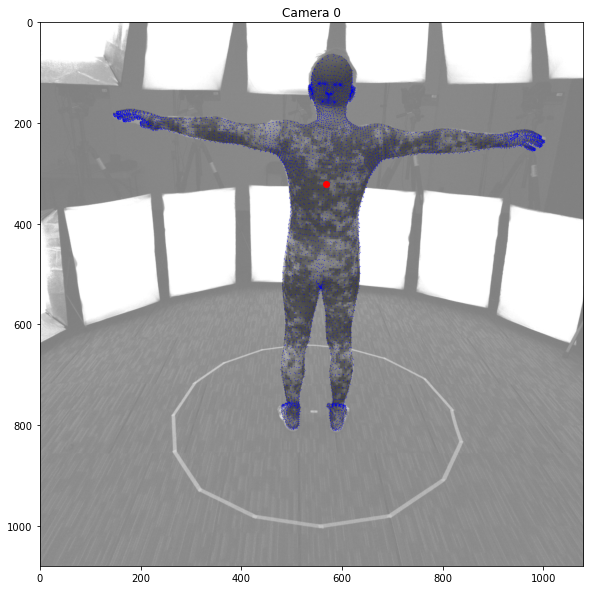

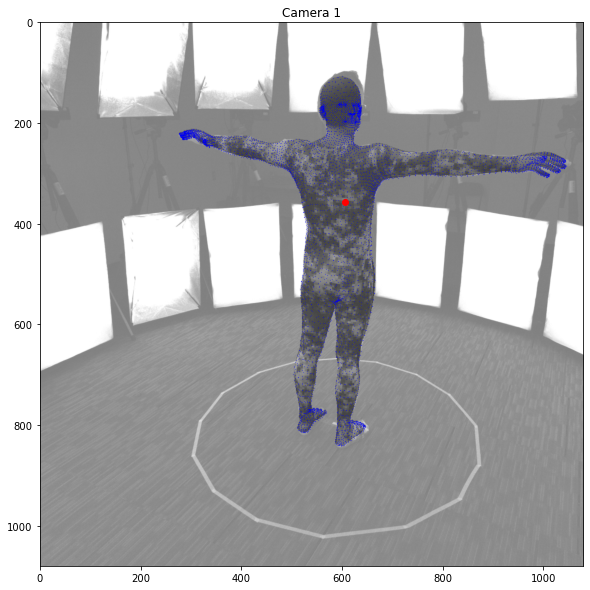

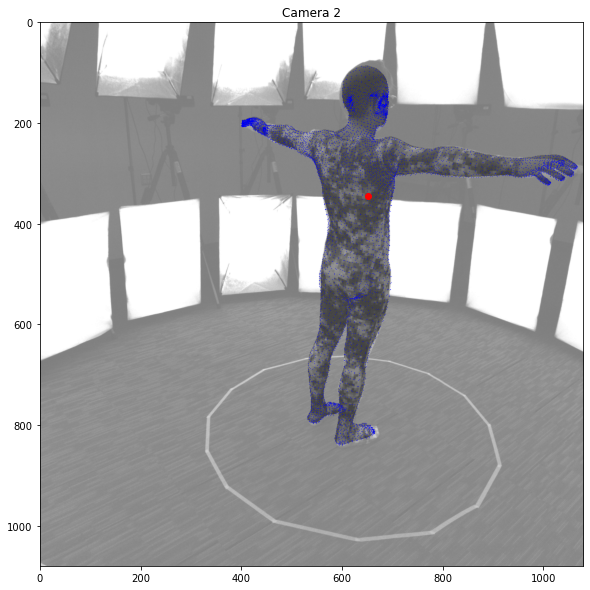

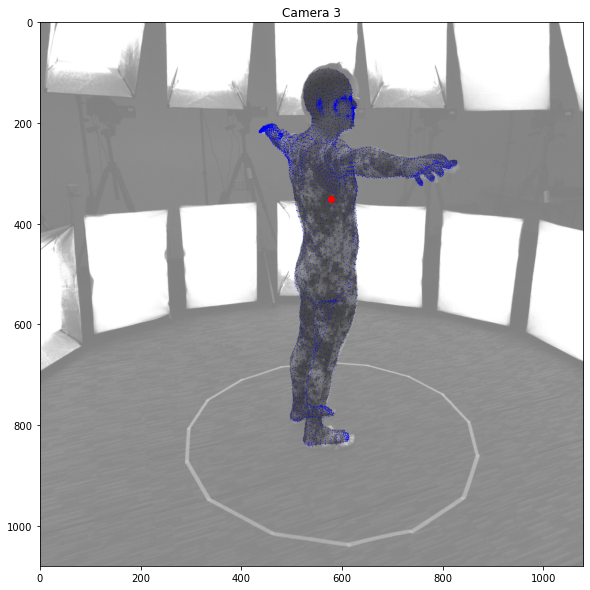

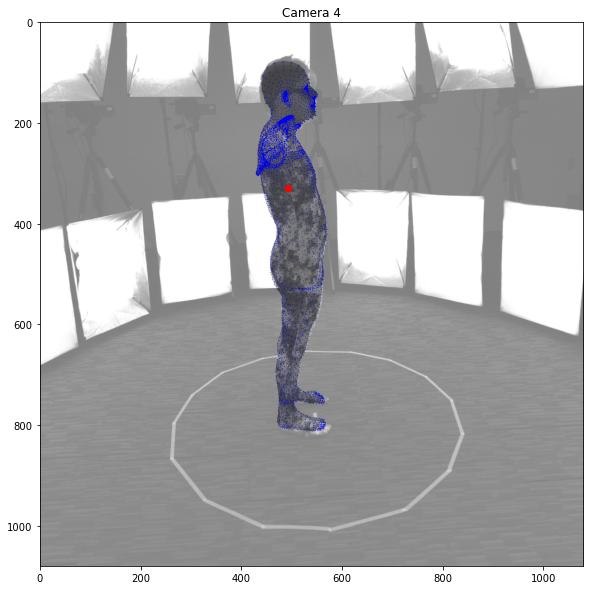

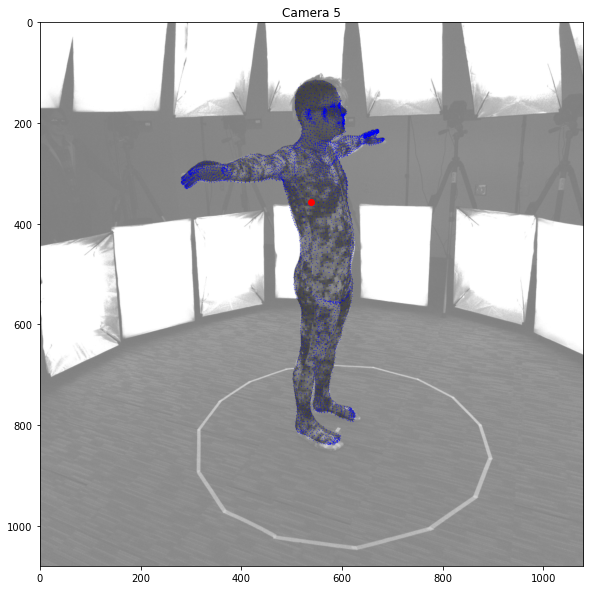

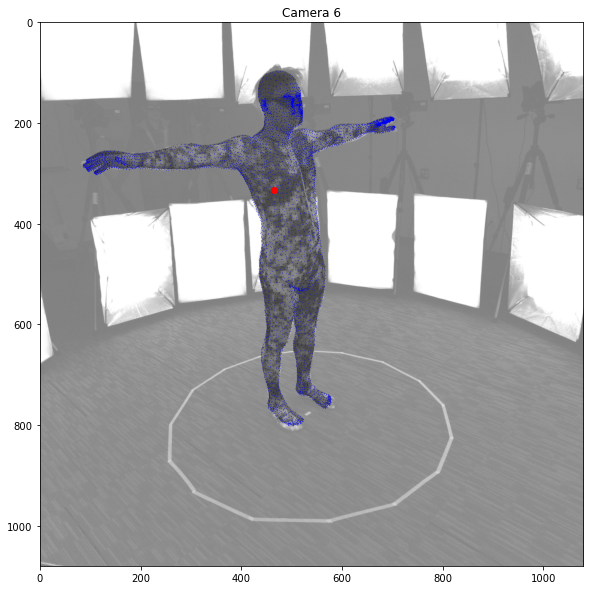

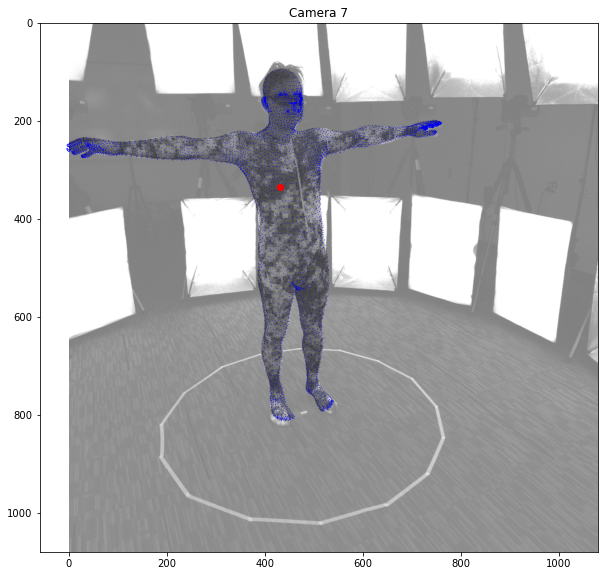

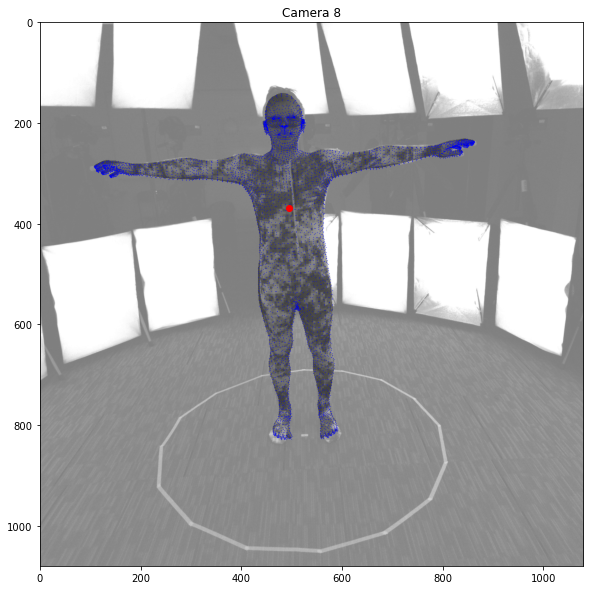

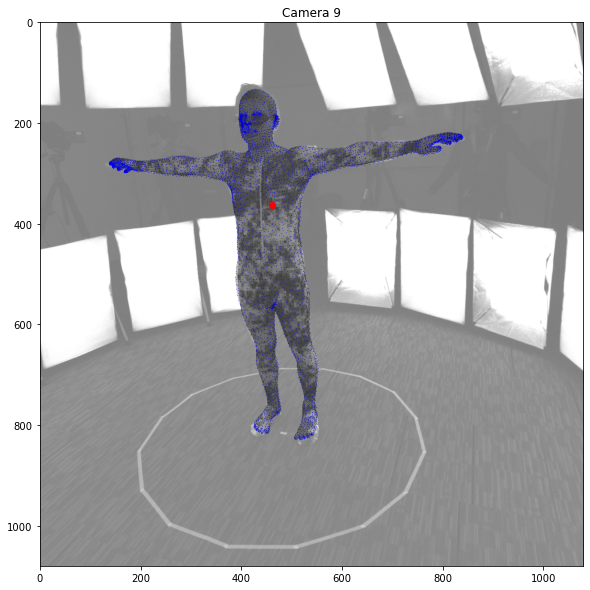

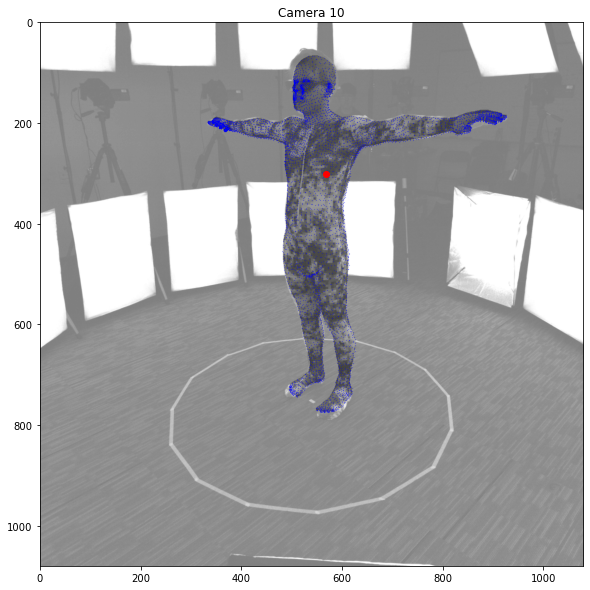

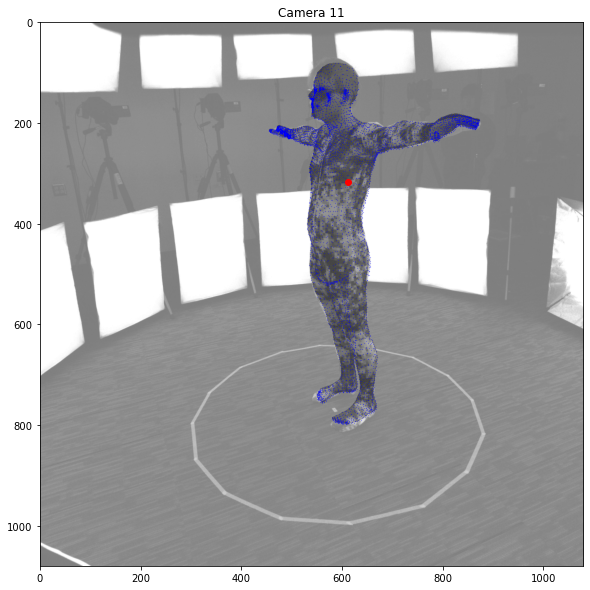

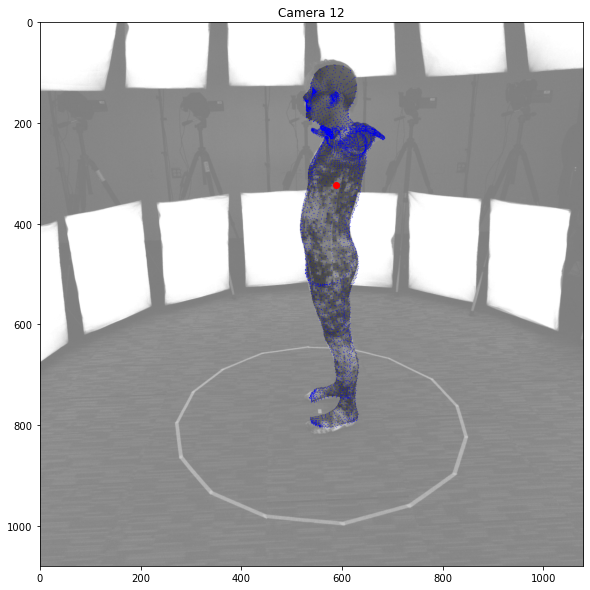

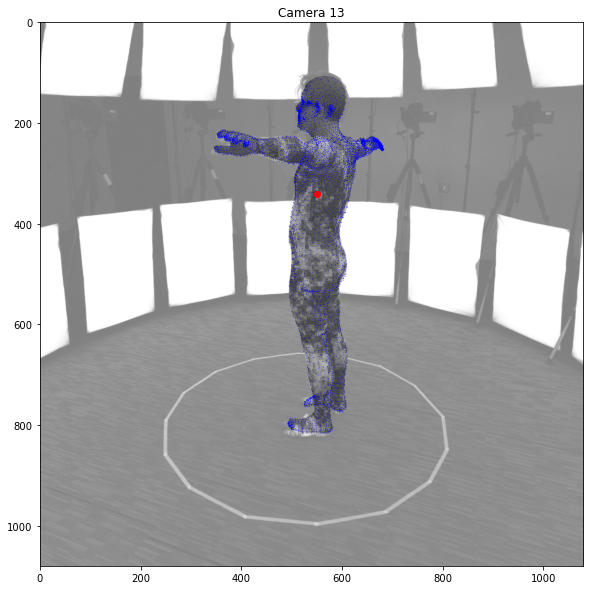

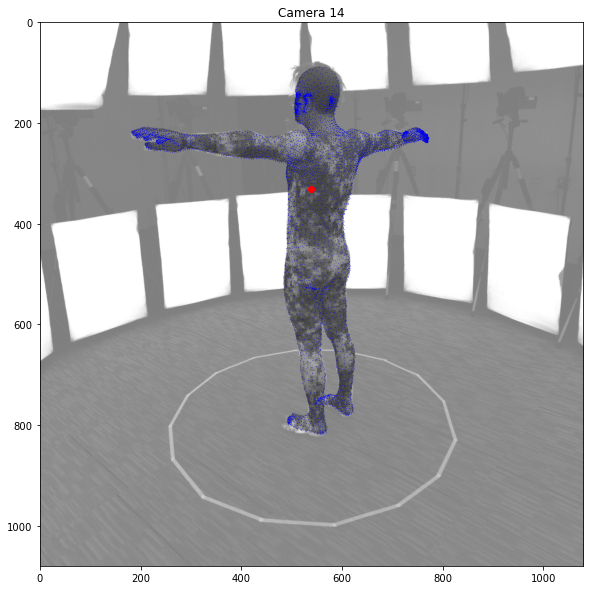

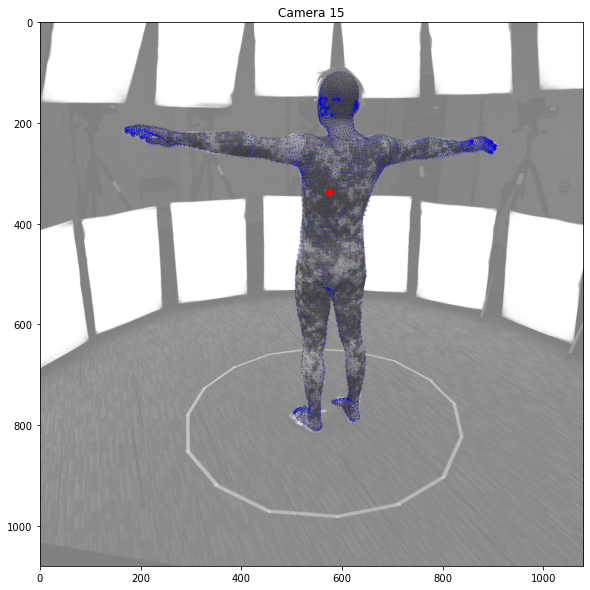

In [15]:
%matplotlib inline
for i in range(16):
    plt.figure(figsize=(10, 10))
    # bg
    img_bg = img_refs[i]
    img_bg = cv2.flip(img_bg, -1)
    plt.imshow(img_bg, cmap='gray')
    
    # mesh from pytorch3d
    img_mesh = images_rendered[i].squeeze().detach().cpu().numpy()[..., :3]
    img_mesh2 = img_mesh
    img_mesh2 = cv2.flip(img_mesh2, -1)
    plt.imshow(img_mesh2, alpha=0.5, cmap='gray')
    
    pts = mesh_points[i]
    pts_small_x = (pts[:, 0] - (4000-2160)*0.5) * image_size/2160
    pts_small_y = pts[:, 1] * image_size/2160
    pts_small = np.stack([pts_small_x, pts_small_y]).T
    pts_center = np.mean(pts_small, axis=0)
    plt.scatter(pts_small[:, 0], pts_small[:, 1], c='b', s=0.01)
    plt.title('Camera {}'.format(i))
    
    # plot centers
    plt.scatter(pts_center[0], pts_center[1], c='r')
    
    if i == 0:
        print('reference image:', np.max(img_bg), img_bg.dtype, img_bg.shape)
        print('rendered pytorch image :', np.max(img_mesh), img_mesh.dtype, img_mesh.shape, ', {:,.2f} Mb'.format(img_mesh.nbytes * 0.000001), np.max(img_mesh))
        print('rendered pytorch image2:', np.max(img_mesh2), img_mesh2.dtype, img_mesh2.shape, ', {:,.2f} Mb'.format(img_mesh2.nbytes * 0.000001), np.max(img_mesh2))
    plt.show()

# Train

In [ ]:
def visualize_LR(e, lr, losses, images, imgR, out_path):
    cams = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']
    img_meshes = []
    for i in range(len(images)):
        img = images[i].detach().squeeze(0).cpu().numpy()
        img_mesh = np.clip(cv2.flip(img, -1), a_min=0.0, a_max=1.0)
        img_meshes.append(img_mesh)
        
    fig = plt.figure(figsize=(18, 3), tight_layout=True)
    
    gs = fig.add_gridspec(2, 12)
    for r in range(2):
        for c in range(8):
            i = r*8 + c
            ax = fig.add_subplot(gs[r, c])
            ax.set_title('{}'.format(cams[i]))
            ax.imshow(img_meshes[i], cmap='gray')
            ax.set_xticks([])
            ax.set_yticks([])
    ax = fig.add_subplot(gs[:, 8:10])
    ax.plot(losses)
    ax.set_title('loss={:.8f}'.format(losses[-1]))
    
    ax = fig.add_subplot(gs[:, 10:12])
    imgR2 = imgR.squeeze().detach().cpu().numpy()
    imgR2 = np.clip(imgR2, a_min=0.0, a_max=1.0)
    ax.imshow(imgR2, cmap='gray', vmin=0, vmax=1.0)
    ax.set_title('Learned Texturemap')
    
    plt.suptitle('Epoch: {:<10}  lr: {:<.4f}'.format(e, lr))
    plt.savefig(out_path, dpi=150)
    plt.close('all')
    
    saved_img = imageio.imread(save_path)
    return saved_img

def get_gpu_stats(output_str=True):
    mb_reserved = torch.cuda.memory_reserved() * 0.000001
    mb_alloc = torch.cuda.memory_allocated() * 0.000001
    mb_cached = torch.cuda.memory_cached() * 0.000001
    if output_str:
        return 'alloc={:,.0f}MB | cached={:,.0f}MB | reserved={:,.0f}MB'.format(mb_alloc, mb_cached, mb_reserved)
    else:
        return mb_alloc, mb_cached, mb_reserved

In [ ]:
save_path = r'./4_data/output/4b/temp_plot.png'
saved_img = visualize_LR(0, 0, [100, 10, 1], images_rendered, texture_map, save_path)
plt.figure(figsize=(15, 3))
plt.imshow(saved_img)

# Init mesh & texturemap

In [ ]:
del model
print('----- torch.cuda.empty_cache() -----')
torch.cuda.empty_cache()
bytes_alloc = torch.cuda.memory_allocated()
print('torch.cuda.memory_allocated(): {:,.2f} Mb'.format(bytes_alloc * 0.000001))
bytes_cached = torch.cuda.memory_cached()
print('torch.cuda.memory_cached(): {:,.2f} Mb'.format(bytes_cached * 0.000001))

model = Model(device_gpu, img_dir=img_dir, cameras=cameras, meshes=meshes, image_refs=img_refs, texturemap_shape=texturemap_shape, image_size=image_size)
stat_gpu = model.stat_gpu
print(stat_gpu)

In [ ]:
save_path = r'./4_data/output/4b/temp_plot.png'

# filename_output = './4_data/output/4b/out.gif'
# writer = imageio.get_writer(filename_output, mode='I', duration=0.3)
now = datetime.now()
hour = str(now.hour)
minute = str(now.minute)
date_str = '{}{:>02}{:>02}_{:>02}h{:>02}m'.format(now.year, now.month, now.day, hour, minute)
log_path = './4_data/output/4b/log_{}.txt'.format(date_str)
__output_log(log_path, '========== {} Start ==========================\n'.format(date_str))
print('Log output: {}'.format(log_path))

optimizer = torch.optim.Adam(model.parameters(), lr=1.0)

loop = tqdm_notebook(range(1000000000))

losses = []
loss_belows, loss_aboves = 0, 0
losses_below, losses_above = [], []
with torch.autograd.profiler.profile() as prof:
    for e in loop:
        stat_str = '1 {:<21}: {}\n'.format('epoch starts'.format(e), get_gpu_stats())
        output_texels = (e % 10 == 0)
        
        if e > 0 and e % 200 == 0:
            optimizer.param_groups[0]['lr'] *= 0.5
            
        t0 = time.time()
        optimizer.zero_grad()
        stat_str += '2 {:<21}: {}\n'.format('optimizer.zero_grad()', get_gpu_stats())
        t1 = time.time()
        
        if output_texels:
            loss, images, texels, stat_gpu = model()
        else:
            loss, _, _, stat_gpu = model()
        stat_str += '3 {:<21}: {}\n'.format('forward', get_gpu_stats())
        stat_str += stat_gpu
        t2 = time.time()
        loss.backward()
        stat_str += '4 {:<21}: {}\n'.format('backward', get_gpu_stats())
        t3 = time.time()
        
        optimizer.step()
        stat_str += '5 {:<21}: {}\n'.format('optimizer.step()', get_gpu_stats())
        t4 = time.time()
        losses.append(loss)
        losses_below.append(loss_belows)
        losses_above.append(loss_aboves)

        loop.set_description('[{}/{}] loss={:.6f}'.format(e, len(loop), loss.data))
        lr = optimizer.param_groups[0]['lr']
        
        if output_texels:
            # Save outputs to create a GIF. 
            t10 = time.time()
            image_out = visualize_LR(e, lr, losses, images, texels, save_path)
            plt.figure()
            plt.imshow(image_out)
            plt.title("iter: %d, lr: %0.4f, loss: %0.8f" % (e, lr, loss.data))
            plt.grid("off")
            plt.axis("off")
            plt.show()
            plt.close('all')
            
            texels_np = model.texture_maps.clone().cpu().numpy()
            np.save('./4_data/output/4b/texturemap.npy', texels_np)
            del texels_np
            
            texturemap_out = (255.0*np.clip(model.texture_maps.clone().squeeze().cpu().numpy(), a_min=0, a_max=1.0)).astype(np.uint8)
            im = Image.fromarray(texturemap_out)
            im.save('./4_data/output/4b/texturemap_learned.png', dpi=(600, 600))
            t11 = time.time()

#             image_out = image_out / 255.0
#             image_out = np.clip(image_out, 0, 1)
#             image_out = img_as_ubyte(image_out)
#             writer.append_data(image_out)
            t12 = time.time()
            
            __output_log(log_path, '{:03} | plot({:.2f}s) | gif({:.2f}s)\n'.format(e+1, t11-t10, t12-t11))
            stat_str += '  {:<21}: {}\n'.format('plotting', get_gpu_stats())
        # execution time
        t01 = t1-t0
        t12 = t2-t1
        t23 = t3-t2
        t34 = t4-t3
        t5 = time.time()
        
        mb_alloc = torch.cuda.memory_allocated() * 0.000001
        mb_cached = torch.cuda.memory_cached() * 0.000001
        now = datetime.now()
        hour = str(now.hour)
        minute = str(now.minute)
        second = str(now.second)
        now_str = '{:>02}:{:>02}:{:>02}'.format(hour, minute, second)
        __output_log(log_path, '{} | {:03} | {:.2f}s | lr={:.8f} | loss={:.6f} | loss_below={:.6f} | loss_above={:.6f} | zero_grad({:.2f}s) | forward({:.2f}s) | backward({:.2f}s) | step({:.2f}s) | GPU_allocated({:,.2f}Mb) | GPU_cached({:,.2f}Mb)\n'.format(now_str, e+1, t5-t0, lr, loss, loss_belows, loss_aboves, t01, t12, t23, t34, mb_alloc, mb_cached))
        
        # clean up
        if output_texels:
            del loss, images, texels
        else:
            del loss
        stat_str += '7 {:<21}: {}\n'.format('clean up', get_gpu_stats())

        torch.cuda.empty_cache()
        stat_str += '8 {:<21}: {}\n'.format('empty_cache()', get_gpu_stats())
        __output_log(log_path, '{}'.format(stat_str))

# print(prof.key_averages().table(sort_by="cuda_time"))
# writer.close()

In [ ]:
# plt.figure()
# # plt.plot(losses, 'k')
# plt.plot(losses_above, 'r')
# plt.plot(losses_below, 'b')

In [ ]:
loss, images, texels, stat_str = model()
print(stat_str)

In [ ]:
texture_maps = texels.detach().squeeze().cpu()
td = texels.detach().cpu()
print(td.shape)
print(torch.min(td),',', torch.max(td))

td_a = torch.clamp(-1.0*texture_maps, min=0.0)
print('n_above:', torch.sum(td_a > 0.0))
td_b = torch.clamp(texture_maps, min=1.0) - torch.ones(texture_maps.shape)
print('n_below:', torch.sum(td_b > 1.0))
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(td_a, vmin=0, vmax=1.0)
ax[0].set_title('Pixels > 1.0')
ax[1].imshow(td_b, vmin=0, vmax=1.0)
ax[1].set_title('Pixels < 0.0')
plt.figure()
plt.imshow(td.clone().squeeze().numpy(), cmap='gray', vmin=0, vmax=1.0)

### load clean plate


#### render clean plate

In [ ]:
# mask
backgrounds = []
masks = []
for i in range(len(images)):
    img = images[i].detach().squeeze().cpu().numpy()[..., 0]
    img = np.clip(img, a_min=0, a_max=1.0)
    mask = (img < 1).astype(np.float32)
    clean_plate = clean_plates[i]

    bg = clean_plate * (1.0 - mask)
    bg = bg + mask*255.0
    bg /= 255.0
    bg = np.clip(bg, a_min=0, a_max=1.0)
    backgrounds.append(bg)
    masks.append(mask)
print(np.max(bg))
fig, ax = plt.subplots(1, 3, figsize=(24, 8))
ax[0].imshow(bg, cmap='gray')
ax[0].invert_yaxis()
ax[1].imshow(img, cmap='gray')
ax[1].invert_yaxis()
ax[1].set_title('{:.2f} <= pixels <= {:.2f} | mean({:.2f})'.format(np.min(img), np.max(img), np.mean(img)))
ax[2].imshow(mask)
ax[2].invert_yaxis()
ax[2].set_title('mask')
plt.show()

In [ ]:
save_dir = './4_data/output/4b'
for i in range(len(images)):
    print(' ', i+1, end='')
    fig, ax = plt.subplots(1, 2, figsize=(24, 12), tight_layout=True)
    img = images[i].detach().squeeze().cpu().numpy()[..., 0]
    img = img * backgrounds[i]
    ax[0].imshow(img, cmap='gray', vmin=0, vmax=1)
    ax[0].invert_yaxis()
    ax[1].imshow(img_refs[i], cmap='gray')
    ax[1].invert_yaxis()
    plt.savefig(save_dir + '/compare_cam{}.png'.format(i+1), dpi=300)
print(save_dir)


### visualize

In [ ]:
%matplotlib inline
fig, ax = plt.subplots(16, 1, figsize=(15, 140))
ax = ax.ravel()
for i in range(len(ax)):
    img_mesh = images_rendered[i]
    img_mesh = cv2.flip(img_mesh, -1)
    img_bg = image_refs[i]
    img_bg = cv2.flip(img_bg, -1)
    ax[i].imshow(img_bg)

    img_mesh_large = np.zeros(img_bg.shape)
    img_mesh_padded = cv2.copyMakeBorder(img_mesh, 0, 0, int((4000-2160)/2), int((4000-2160)/2), 0, None, [0, 0, 0])
    ax[i].imshow(img_mesh, alpha=0.5)
    
    pts = mesh_points[i]
    pts_small_x = (pts[:, 0] - (4000-2160)*0.5) * rendered_image_size/2160
    pts_small_y = pts[:, 1] * rendered_image_size/2160
    pts_small = np.stack([pts_small_x, pts_small_y]).T
    pts_center = np.mean(pts_small, axis=0)
#     ax[i].scatter(pts[:, 0], pts[:, 1], c='r', s=0.1)
#     ax[i].scatter(pts_small[:, 0], pts_small[:, 1], c='r', s=0.01)
    ax[i].set_title('Camera {}'.format(cams[i]))
    
    # plot centers
    ax[i].scatter(pts_center[0], pts_center[1], c='r')


In [ ]:
writer.close()

In [ ]:
class Model(nn.Module):
    def __init__(self, meshes, image_refs, renderers, texture_maps):
        super().__init__()
        self.meshes = meshes
        self.device = meshes.device
        self.renderers = renderers
        self.register_buffer('image_refs', image_refs)

        self.texture_maps = nn.Parameter(texture_maps.to(meshes.device), requires_grad=True)
        
    def forward(self):
        loss = 0
        images = []
        for i in range(len(self.renderers)):
            image = self.renderers[i](meshes_world=self.meshes, texture_maps=self.texture_maps)
            loss_i = torch.mean((image.squeeze()[..., :3] - self.image_refs[i]) ** 2)
            images.append(image)
            loss = loss + loss_i
        loss /= len(self.renderers)

        return loss, images, self.texture_maps.data

# After traning

In [ ]:
plt.figure()
plt.plot(losses)
plt.show()

In [ ]:
plt.figure()
plt.imshow(model.texture_maps.detach().cpu().numpy()[0, :, :, :])
plt.savefig('./4_data/output/4b/texturemap_learned.png', dpi=600)
plt.show()

In [ ]:
x = torch.randn((1, 1), requires_grad=True)
with torch.autograd.profiler.profile() as prof:
    print(prof)
    for _ in range(100):  # any normal python code, really!
        y = x ** 2
        y.backward()
# NOTE: some columns were removed for brevity
print(prof.key_averages().table(sort_by="self_cpu_time_total"))

In [ ]:
torch.cuda.memory_stats(device=device_gpu)

In [ ]:
print(torch.cuda.memory_summary(device=device_gpu, abbreviated=True))

In [ ]:
mem_stats = torch.cuda.memory_stats(device=device_gpu)
for k, v in mem_stats.items():
    print('{}: {}'.format(k, v))

In [ ]:
print(torch.cuda.max_memory_allocated(device=device_gpu))